In [63]:
import os
from transformers import (
    AutoModel,
    AutoModelForCausalLM,
    AutoTokenizer,
    GenerationMixin,
    AutoConfig,
    set_seed,
)
from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_utils import PreTrainedModel
from datasets import load_dataset, concatenate_datasets, DatasetDict, load_from_disk
import torch
import torch.nn as nn
from transformers.cache_utils import Cache
from typing import Callable, List, Optional, Tuple, Union


In [41]:
import torch
import time
import concurrent.futures

# Function to convert tensor to list
def tensor_to_list(tensor):
    return tensor.to(torch.float16).tolist()

# Optimized function for batch processing
def process_in_batches(enc_output, num_workers=4):
    input_embeds = enc_output.detach().cpu().to(torch.float16)  # Move to CPU once

    # Split tensor into chunks for parallel processing
    num_chunks = min(num_workers, input_embeds.shape[0])  # Limit chunks to batch size
    print(num_chunks)
    chunks = torch.chunk(input_embeds, num_chunks, dim=0)

    # Process in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(tensor_to_list, chunks))

    # Flatten nested lists
    return [item for sublist in results for item in sublist]

# Create a large tensor of shape (4096, 1) on GPU
enc_output = torch.randn(4096, 1, device="cuda")

# Measure time for sequential conversion
start_time = time.time()
sequential_result = enc_output.cpu().to(torch.float16).tolist()
sequential_time = time.time() - start_time

# Measure time for parallel conversion
start_time = time.time()
parallel_result = process_in_batches(enc_output, num_workers=100)
parallel_time = time.time() - start_time

# Verify results match and print timing
(sequential_time, parallel_time, sequential_result == parallel_result)


100


(0.002638578414916992, 0.010694503784179688, True)

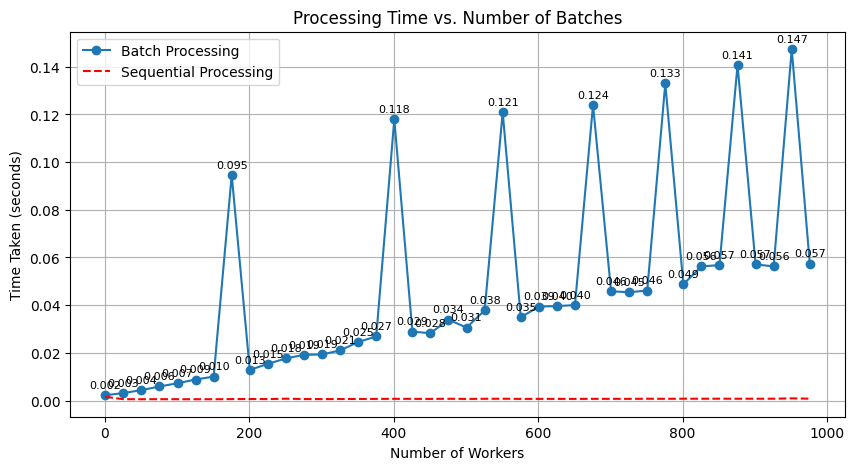

In [60]:
import torch
import time
import concurrent.futures
import matplotlib.pyplot as plt

def tensor_to_list(tensor):
    return tensor.to(torch.float16).tolist()

def process_in_batches(enc_output, num_workers):
    input_embeds = enc_output.detach().cpu().to(torch.float16)  # Move to CPU once
    num_chunks = min(num_workers, input_embeds.shape[0])  # Limit chunks to batch size
    chunks = torch.chunk(input_embeds, num_chunks, dim=0)
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(tensor_to_list, chunks))
    
    return [item for sublist in results for item in sublist]

# Create a large tensor of shape (4096, 1) on GPU
enc_output = torch.randn(4096, 1, device="cuda")

# Measure sequential time (average over 3 runs)
sequential_times = []
# for _ in range(3):
#     start_time = time.time()
#     enc_output.cpu().to(torch.float16).tolist()
#     sequential_times.append(time.time() - start_time)
# sequential_time_avg = sum(sequential_times) / len(sequential_times)

# Measure time for different batch sizes (average over 3 runs per worker count)
worker_counts = list(range(1, 1001, 25))  # Test from 1 to 1000 in steps of 50
times = []

for num_workers in worker_counts:
    batch_times = []
    batch_sequentials = []
    for _ in range(5):
        start_time = time.time()
        process_in_batches(enc_output, num_workers)
        batch_times.append(time.time() - start_time)

        start_time = time.time()
        enc_output.cpu().to(torch.float16).tolist()
        batch_sequentials.append(time.time() - start_time)
    times.append(sum(batch_times) / len(batch_times))
    sequential_times.append(sum(batch_sequentials) / len(batch_sequentials))

# Plot results



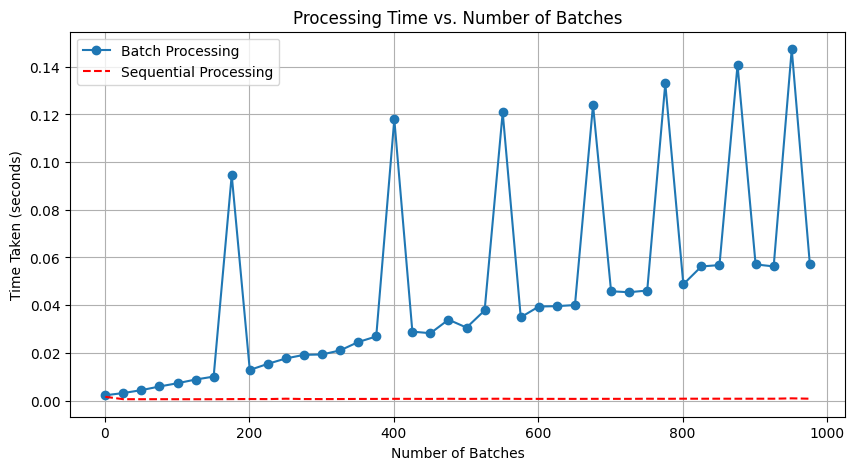

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(worker_counts, times, marker='o', linestyle='-', label="Batch Processing")
plt.plot(worker_counts, sequential_times, color='r', linestyle='--', label="Sequential Processing")
plt.xlabel("Number of Batches")
plt.ylabel("Time Taken (seconds)")
plt.title("Processing Time vs. Number of Batches")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(worker_counts, times, marker='o', linestyle='-', label="Batch Processing")
plt.plot(worker_counts, sequential_times, color='r', linestyle='--', label="Sequential Processing")

# Annotate each point in batch processing
for i, txt in enumerate(times):
    plt.annotate(f"{txt:.3f}", (worker_counts[i], times[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

plt.xlabel("Number of Workers")
plt.ylabel("Time Taken (seconds)")
plt.title("Processing Time vs. Number of Batches")
plt.legend()
plt.grid()
plt.show()

In [64]:
import requests
requests.post("http://localhost:9000/clear")

<Response [200]>

In [65]:
class XCodeEncDecConfig(PretrainedConfig):
    model_type = "xcodeencdec"

    def __init__(
        self,
        enc_dec_origin_model: Optional[str] = None,
        enc_num_layers: int = 1,
        middle_path: Optional[str] = None,
        dec_num_layers: int = 4,
        middle_num_layers: Optional[int] = None,
        is_middle_api: bool = False,
        enc_config:dict = {},
        middle_config:dict = {},
        dec_config:dict = {},
        other_config_path: Optional[str] = None,
        **kwargs,
    ):
        self.enc_dec_origin_model = enc_dec_origin_model
        self.enc_num_layers = enc_num_layers
        self.middle_path = middle_path
        self.is_middle_api = is_middle_api
        self.middle_num_layers = middle_num_layers
        self.dec_num_layers = dec_num_layers
        self.enc_config = enc_config
        self.middle_config = middle_config
        self.dec_config = dec_config
        if other_config_path:
            other_config_dict = AutoConfig.from_pretrained(other_config_path).to_dict()
        else:
            other_config_dict = {}
        super().__init__(**other_config_dict ,**kwargs)

## Pin Memory

In [66]:
import time

class XCodeEncDecModel(PreTrainedModel):
    config_class = XCodeEncDecConfig

    def __init__(self, config: XCodeEncDecConfig):
        super().__init__(config)
        self.enc_time = []
        self.conversion_time = []
        self.network_time = []
        self.dec_time = []
        self.middle_time = []
        self.concat_time = []
        self.last_middle = None
        self.conversion_time_1 = []
        self.conversion_time_2 = []
        self.cloud_conversion_time_1 = []
        self.cloud_conversion_time_2 = []
        

        # Set up Encoder
        enc_config = AutoConfig.from_pretrained(config.enc_dec_origin_model)
        self.enc = AutoModel.from_config(enc_config, torch_dtype=torch.bfloat16)
        self.enc.layers = self.enc.layers[: config.enc_num_layers]
        self.enc.norm = nn.Identity()

        # Set up Decoder
        dec_config = AutoConfig.from_pretrained(config.enc_dec_origin_model)
        self.dec = AutoModelForCausalLM.from_config(
            dec_config, torch_dtype=torch.bfloat16
        )
        self.dec.model.layers = self.dec.model.layers[- config.dec_num_layers :]
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Union[Cache, List[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = False,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        cache_position: Optional[torch.LongTensor] = None,
    ) -> Union[Tuple, CausalLMOutputWithPast]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict


        enc_start = time.time()
        enc_output = self.enc(
            input_ids=input_ids,
            attention_mask=attention_mask,
            use_cache=False,
        )
        enc_end = time.time()
        self.enc_time.append(enc_end - enc_start)


        conversion_time_start_1 = time.time()
        if self.last_middle is None:
            input_embeds_list = enc_output.last_hidden_state.detach().to(torch.float16).tolist()
        else: 
            input_embeds_list = enc_output.last_hidden_state[:,-1:,:].detach().to(torch.float16).tolist()
        # attention_mask_list = attention_mask.detach().cpu().numpy().tolist() if attention_mask is not None else None
        conversion_time_end_1 = time.time()
        conversion_time = conversion_time_end_1 - conversion_time_start_1
        self.conversion_time_1.append(conversion_time)
        
        network_time_start = time.time()
        import requests
        network_time = None
        conversion_time_2 = None

        
        # print(enc_output.last_hidden_state.shape)
        # Prepare request payload
        payload = {
            "inputs_embeds": input_embeds_list,
        }
        cloud_concat = 0
        # Make request to the middle model API
        try:
            response = requests.post("http://localhost:9000/predict", json=payload)
            response.raise_for_status()  # Raise an exception for bad status codes
            network_time_end = time.time()
            
            conversion_time_start_2 = time.time()
            # Convert the response back to tensor
            response_json = response.json()
            middle_output_list = response_json["last_hidden_state"]
            conversion_time_cloud_1 = response_json["conversion_time_1"]
            conversion_time_cloud_2 = response_json["conversion_time_2"]
            middle_time = response_json["middle_time"]
            cloud_concat = response_json["concat_time"]
            middle_hidden_state = torch.tensor(middle_output_list, dtype=torch.float16, pin_memory=True).to(device=self.dec.device, dtype=torch.bfloat16, non_blocking=True)
            
            # Create a BaseModelOutputWithPast-like object
            class MiddleOutput:
                def __init__(self, last_hidden_state):
                    self.last_hidden_state = last_hidden_state
            
            # network_middle_output = MiddleOutput(last_hidden_state=middle_hidden_state)
            conversion_time_end_2 = time.time()
            conversion_time = conversion_time + (conversion_time_end_2 - conversion_time_start_2) + conversion_time_cloud_1 + conversion_time_cloud_2
            
            self.conversion_time_2.append((conversion_time_end_2 - conversion_time_start_2))
            self.cloud_conversion_time_1.append(conversion_time_cloud_1)
            self.cloud_conversion_time_2.append(conversion_time_cloud_2)
        except requests.exceptions.RequestException as e:
            network_time_end = time.time()
            raise RuntimeError(f"Failed to get middle model output: {str(e)}")
            
        network_time = network_time_end - network_time_start - conversion_time_cloud_1 - conversion_time_cloud_2 - middle_time - cloud_concat
        
        
        self.network_time.append(network_time)
        self.middle_time.append(middle_time)
        
        concat_time_start = time.time()
        if self.last_middle is None:
            middle_output = middle_hidden_state
            
        else: 
            middle_output = torch.concat((self.last_middle, middle_hidden_state), dim=1)
        concat_time_end = time.time()
        self.last_middle = middle_output
        self.concat_time.append(concat_time_end - concat_time_start + cloud_concat)
        # print(middle_output.shape)
        dec_start = time.time()
        dec_output = self.dec(
            inputs_embeds=middle_output,
            attention_mask=attention_mask,
            use_cache=False,
            labels=labels,
        )
        dec_end = time.time()
        self.dec_time.append(dec_end - dec_start)
        self.conversion_time.append(conversion_time)
        return dec_output
    def prepare_inputs_for_generation(
        self, input_ids, past_key_values=None, attention_mask=None, inputs_embeds=None, **kwargs
    ):
        return self.dec.prepare_inputs_for_generation(input_ids, past_key_values, attention_mask, inputs_embeds, **kwargs)

class XCodeModelForCausalLM(XCodeEncDecModel, GenerationMixin):
    def save_pretrained(
        self,
        save_directory: Union[str, os.PathLike],
        is_main_process: bool = True,
        save_function: Callable = torch.save,
        push_to_hub: bool = False,
        max_shard_size: Union[int, str] = "5GB",
        safe_serialization: bool = False,
        variant: Optional[str] = None,
        token: Optional[Union[str, bool]] = None,
        save_peft_format: bool = True,
        **kwargs,
    ):
        state_dict = {k: v for k, v in self.state_dict().items()}
    
        # Remove state_dict from kwargs if it's present
        kwargs.pop('state_dict', None)
        
        # Call the parent class's save_pretrained method with the filtered state_dict
        super().save_pretrained(
            save_directory,
            state_dict=state_dict,
            is_main_process=is_main_process,
            save_function=save_function,
            push_to_hub=push_to_hub,
            max_shard_size=max_shard_size,
            safe_serialization=False,
            #safe_serialization=safe_serialization,
            variant=variant,
            token=token,
            save_peft_format=save_peft_format,
            **kwargs,
        )

In [75]:
AutoConfig.register("xcodeencdec", XCodeEncDecConfig)
AutoModel.register(XCodeEncDecConfig, XCodeEncDecModel)
AutoModelForCausalLM.register(XCodeEncDecConfig, XCodeModelForCausalLM)

In [76]:
model = AutoModelForCausalLM.from_pretrained("enc_dec", device_map="cuda:3", torch_dtype=torch.bfloat16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [77]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/CodeQwen1.5-7B-Chat")

In [78]:
from tqdm import tqdm
device = "cuda:3"
prompt = "Write a quicksort algorithm in python."
ITER_NUM = 3
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
# model = model.cuda()
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)
responses = []
for i in tqdm(range(ITER_NUM)):
    import requests
    requests.post("http://localhost:9000/clear")
    model.last_middle = None
    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=512
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    
    responses.append(tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0])

  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 33%|████████████████████████████████████████████████                                                                                                | 1/3 [01:45<03:30, 105.41s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                             

In [71]:
conversion_time = model.conversion_time
middle_time = model.middle_time
network_time = model.network_time
dec_time = model.dec_time
enc_time = model.enc_time
concat_time = model.concat_time
conversion_time_1 = model.conversion_time_1
conversion_time_2 = model.conversion_time_2
conversion_time_cloud_1= model.cloud_conversion_time_1
conversion_time_cloud_2= model.cloud_conversion_time_2

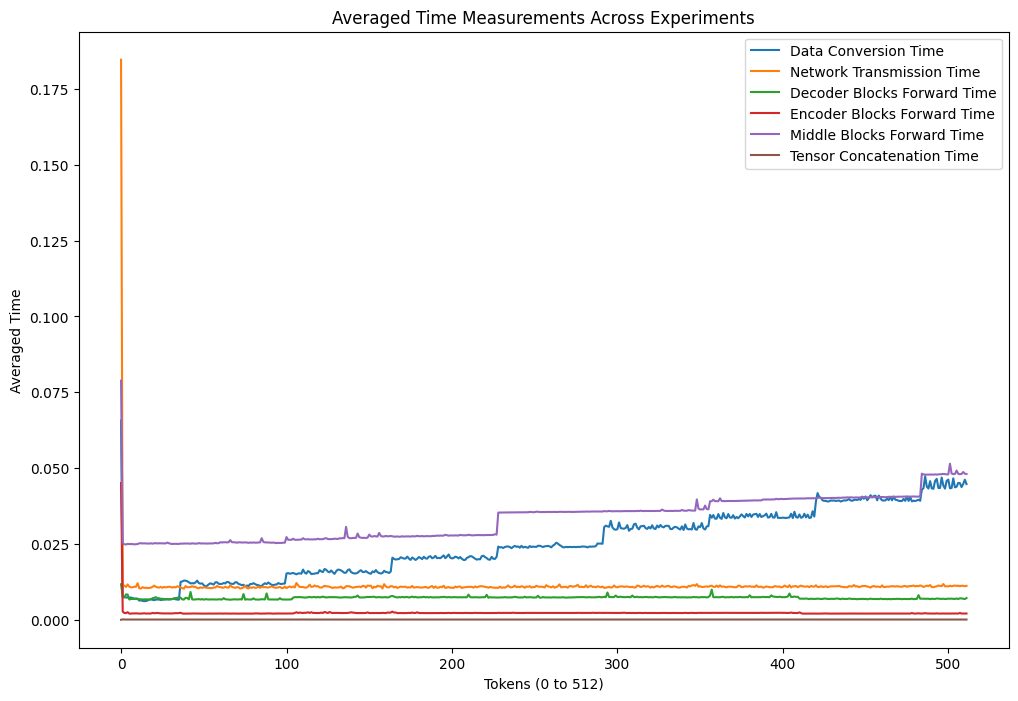

First 10 steps of averaged results:
Data Conversion Time: [0.06566516558329265, 0.007375796635945638, 0.007509390513102214, 0.007347663243611653, 0.007302045822143555, 0.0072523752848307295, 0.007315794626871745, 0.007144530614217122, 0.006949265797932942, 0.007007916768391927]
Network Request Time: [0.18465963999430338, 0.011197566986083984, 0.01124723752339681, 0.010812838872273764, 0.011632601420084635, 0.010877052942911783, 0.010688145955403646, 0.010679483413696289, 0.010916312535603842, 0.010839223861694336]
Decoder Time: [0.011702934900919596, 0.0077936649322509766, 0.007348457972208659, 0.00835728645324707, 0.008286635080973307, 0.006663958231608073, 0.006841739018758138, 0.006858507792154948, 0.006879885991414388, 0.006868282953898112]
Encoder Time: [0.04506452878316244, 0.0026667912801106772, 0.0022291342417399087, 0.002159595489501953, 0.0024836063385009766, 0.0020100275675455728, 0.0020256837209065757, 0.0020882288614908853, 0.002053499221801758, 0.002113183339436849]
Middl

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual lists)
# conversion_time_1 = [...]  # Replace with actual data
# conversion_time_2 = [...]  # Replace with actual data
# network_time = [...]       # Replace with actual data
# dec_time = [...]           # Replace with actual data
# enc_time = [...]           # Replace with actual data

# Define the number of steps per experiment
steps_per_experiment = 512
num_experiments = 3

# Function to calculate the averaged time for each step across experiments
def average_across_experiments(data):
    return [
        np.mean([data[steps_per_experiment * j + i] for j in range(num_experiments)])
        for i in range(steps_per_experiment)
    ]

# Sum conversion_time_1 and conversion_time_2
# total_conversion_time = [c1 + c2 for c1, c2 in zip(conversion_time_1, conversion_time_2)]

# Apply the function to the summed conversion time and other lists
avg_total_conversion_time = average_across_experiments(conversion_time)
avg_middle_time = average_across_experiments(middle_time)
avg_network_time = average_across_experiments(network_time)
avg_dec_time = average_across_experiments(dec_time)
avg_enc_time = average_across_experiments(enc_time)
avg_concat_time = average_across_experiments(concat_time)

# --- Visualization ---

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(avg_total_conversion_time, label="Data Conversion Time")
plt.plot(avg_network_time, label="Network Transmission Time")
plt.plot(avg_dec_time, label="Decoder Blocks Forward Time")
plt.plot(avg_enc_time, label="Encoder Blocks Forward Time")
plt.plot(avg_middle_time, label="Middle Blocks Forward Time")
plt.plot(avg_concat_time, label="Tensor Concatenation Time")
plt.title("Averaged Time Measurements Across Experiments")
plt.xlabel("Tokens (0 to 512)")
plt.ylabel("Averaged Time")
plt.legend()
plt.show()

# Print the first few averaged values for verification
print("First 10 steps of averaged results:")
print("Data Conversion Time:", avg_total_conversion_time[:10])
print("Network Request Time:", avg_network_time[:10])
print("Decoder Time:", avg_dec_time[:10])
print("Encoder Time:", avg_enc_time[:10])
print("Middle Time:", avg_middle_time[:10])
print("Concat Time:", avg_concat_time[:10])


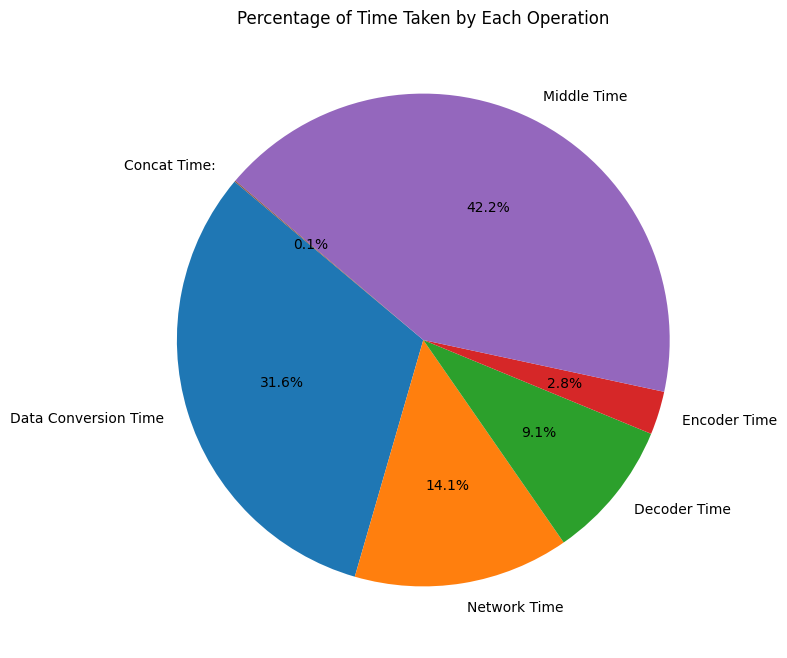

Average Times:
Data Conversion Time: 0.0251
Network Time: 0.0112
Decoder Time: 0.0072
Encoder Time: 0.0023
Middle Time: 0.0335
Concat Time:: 0.0001


In [11]:
# Calculate the average time across all steps and experiments
avg_total_conversion_time = np.mean(conversion_time)
avg_network_time = np.mean(network_time)
avg_dec_time = np.mean(dec_time)
avg_enc_time = np.mean(enc_time)
avg_middle_time = np.mean(middle_time)
avg_concat_time = np.mean(concat_time)
# Aggregate the average times
average_times = {
    "Data Conversion Time": avg_total_conversion_time,
    "Network Time": avg_network_time,
    "Decoder Time": avg_dec_time,
    "Encoder Time": avg_enc_time,
    "Middle Time": avg_middle_time,
    "Concat Time:": avg_concat_time
}

# --- Visualization ---

# Create a pie chart
labels = average_times.keys()
sizes = average_times.values()

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Percentage of Time Taken by Each Operation")
plt.show()

# Print the average times for reference
print("Average Times:")
for label, time in average_times.items():
    print(f"{label}: {time:.4f}")

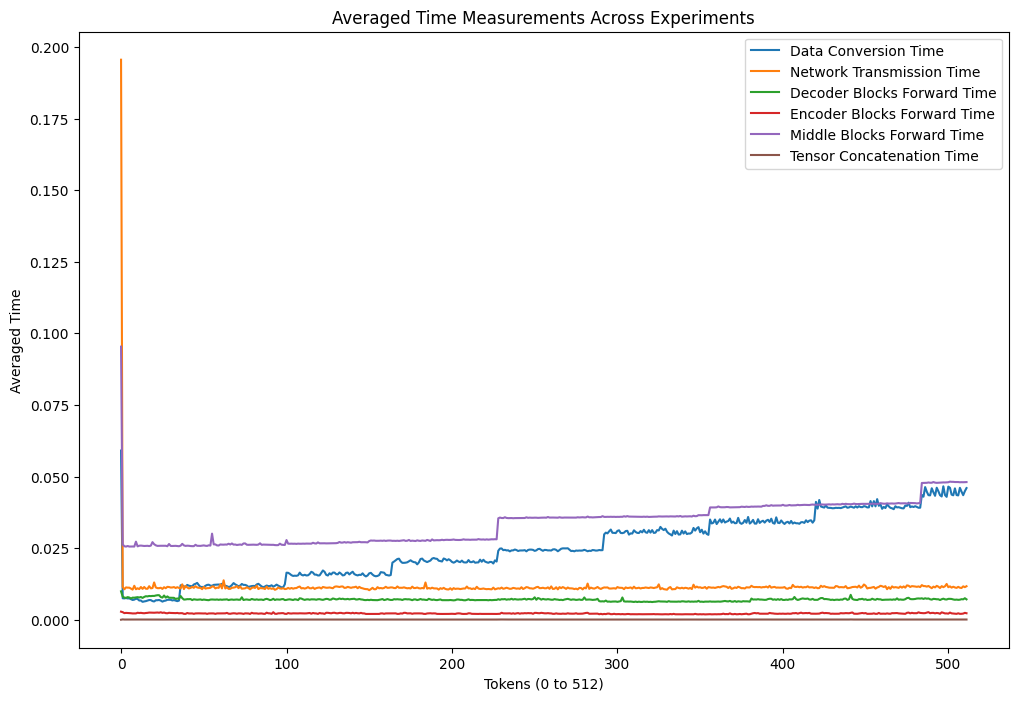

First 10 steps of averaged results:
Data Conversion Time: [0.059071858723958336, 0.007495403289794922, 0.007452090581258138, 0.007575511932373047, 0.00743714968363444, 0.007454713185628255, 0.007172107696533203, 0.006895621617635091, 0.007016658782958984, 0.007321993509928386]
Network Request Time: [0.19556339581807455, 0.011462529500325521, 0.010638872782389322, 0.011283795038859049, 0.01120448112487793, 0.01120154062906901, 0.010839144388834635, 0.010520696640014648, 0.011857748031616211, 0.010648488998413086]
Decoder Time: [0.009909629821777344, 0.00806887944539388, 0.007725874582926433, 0.007640997568766276, 0.007891019185384115, 0.00774383544921875, 0.007416645685831706, 0.007712841033935547, 0.007695674896240234, 0.007769107818603516]
Encoder Time: [0.0028150081634521484, 0.002639611562093099, 0.0023015340169270835, 0.002386172612508138, 0.002349217732747396, 0.0023223559061686196, 0.0022660096486409507, 0.002195596694946289, 0.0022083918253580728, 0.0022068023681640625]
Middle T

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual lists)
# conversion_time_1 = [...]  # Replace with actual data
# conversion_time_2 = [...]  # Replace with actual data
# network_time = [...]       # Replace with actual data
# dec_time = [...]           # Replace with actual data
# enc_time = [...]           # Replace with actual data

# Define the number of steps per experiment
steps_per_experiment = 512
num_experiments = 3

# Function to calculate the averaged time for each step across experiments
def average_across_experiments(data):
    return [
        np.mean([data[steps_per_experiment * j + i] for j in range(num_experiments)])
        for i in range(steps_per_experiment)
    ]

# Sum conversion_time_1 and conversion_time_2
# total_conversion_time = [c1 + c2 for c1, c2 in zip(conversion_time_1, conversion_time_2)]

# Apply the function to the summed conversion time and other lists
avg_total_conversion_time = average_across_experiments(conversion_time)
avg_middle_time = average_across_experiments(middle_time)
avg_network_time = average_across_experiments(network_time)
avg_dec_time = average_across_experiments(dec_time)
avg_enc_time = average_across_experiments(enc_time)
avg_concat_time = average_across_experiments(concat_time)

# --- Visualization ---

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(avg_total_conversion_time, label="Data Conversion Time")
plt.plot(avg_network_time, label="Network Transmission Time")
plt.plot(avg_dec_time, label="Decoder Blocks Forward Time")
plt.plot(avg_enc_time, label="Encoder Blocks Forward Time")
plt.plot(avg_middle_time, label="Middle Blocks Forward Time")
plt.plot(avg_concat_time, label="Tensor Concatenation Time")
plt.title("Averaged Time Measurements Across Experiments")
plt.xlabel("Tokens (0 to 512)")
plt.ylabel("Averaged Time")
plt.legend()
plt.show()

# Print the first few averaged values for verification
print("First 10 steps of averaged results:")
print("Data Conversion Time:", avg_total_conversion_time[:10])
print("Network Request Time:", avg_network_time[:10])
print("Decoder Time:", avg_dec_time[:10])
print("Encoder Time:", avg_enc_time[:10])
print("Middle Time:", avg_middle_time[:10])
print("Concat Time:", avg_concat_time[:10])


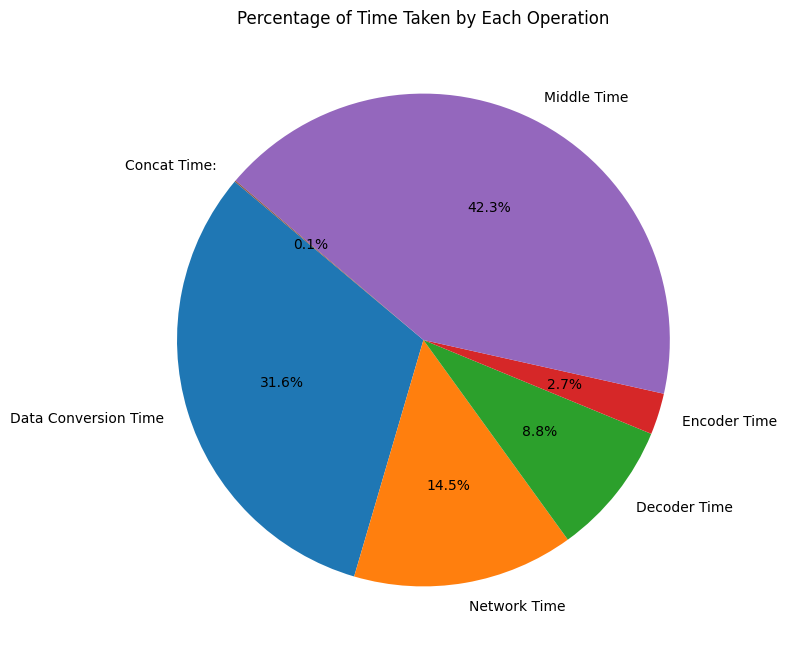

Average Times:
Data Conversion Time: 0.0251
Network Time: 0.0115
Decoder Time: 0.0070
Encoder Time: 0.0022
Middle Time: 0.0337
Concat Time:: 0.0001


In [73]:
# Calculate the average time across all steps and experiments
avg_total_conversion_time = np.mean(conversion_time)
avg_network_time = np.mean(network_time)
avg_dec_time = np.mean(dec_time)
avg_enc_time = np.mean(enc_time)
avg_middle_time = np.mean(middle_time)
avg_concat_time = np.mean(concat_time)
# Aggregate the average times
average_times = {
    "Data Conversion Time": avg_total_conversion_time,
    "Network Time": avg_network_time,
    "Decoder Time": avg_dec_time,
    "Encoder Time": avg_enc_time,
    "Middle Time": avg_middle_time,
    "Concat Time:": avg_concat_time
}

# --- Visualization ---

# Create a pie chart
labels = average_times.keys()
sizes = average_times.values()

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Percentage of Time Taken by Each Operation")
plt.show()

# Print the average times for reference
print("Average Times:")
for label, time in average_times.items():
    print(f"{label}: {time:.4f}")

In [12]:
np.mean(conversion_time)

0.025081300952782232

In [13]:
np.mean(network_time)

0.011207713435093561

In [14]:
np.mean(dec_time)

0.007242195308208466

In [15]:
np.mean(concat_time)

6.346714993317922e-05

In [16]:
np.mean(conversion_time_1)

0.02334938586379091

In [17]:
np.mean(conversion_time_2)

0.0009370059706270695

In [18]:
np.mean(conversion_time_cloud_1)

0.000272250734269619

In [19]:
np.mean(conversion_time_cloud_2)

0.0005226583840946356

## No Pin

In [74]:
import time

class XCodeEncDecModel(PreTrainedModel):
    config_class = XCodeEncDecConfig

    def __init__(self, config: XCodeEncDecConfig):
        super().__init__(config)
        self.enc_time = []
        self.conversion_time = []
        self.network_time = []
        self.dec_time = []
        self.middle_time = []
        self.concat_time = []
        self.last_middle = None
        self.conversion_time_1 = []
        self.conversion_time_2 = []
        self.cloud_conversion_time_1 = []
        self.cloud_conversion_time_2 = []
        

        # Set up Encoder
        enc_config = AutoConfig.from_pretrained(config.enc_dec_origin_model)
        self.enc = AutoModel.from_config(enc_config, torch_dtype=torch.bfloat16)
        self.enc.layers = self.enc.layers[: config.enc_num_layers]
        self.enc.norm = nn.Identity()

        # Set up Decoder
        dec_config = AutoConfig.from_pretrained(config.enc_dec_origin_model)
        self.dec = AutoModelForCausalLM.from_config(
            dec_config, torch_dtype=torch.bfloat16
        )
        self.dec.model.layers = self.dec.model.layers[- config.dec_num_layers :]
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Union[Cache, List[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = False,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        cache_position: Optional[torch.LongTensor] = None,
    ) -> Union[Tuple, CausalLMOutputWithPast]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict


        enc_start = time.time()
        enc_output = self.enc(
            input_ids=input_ids,
            attention_mask=attention_mask,
            use_cache=False,
        )
        enc_end = time.time()
        self.enc_time.append(enc_end - enc_start)


        conversion_time_start_1 = time.time()
        if self.last_middle is None:
            input_embeds_list = enc_output.last_hidden_state.detach().to(torch.float16).tolist()
        else: 
            input_embeds_list = enc_output.last_hidden_state[:,-1:,:].detach().to(torch.float16).tolist()
        # attention_mask_list = attention_mask.detach().cpu().numpy().tolist() if attention_mask is not None else None
        conversion_time_end_1 = time.time()
        conversion_time = conversion_time_end_1 - conversion_time_start_1
        self.conversion_time_1.append(conversion_time)
        
        network_time_start = time.time()
        import requests
        network_time = None
        conversion_time_2 = None

        
        # print(enc_output.last_hidden_state.shape)
        # Prepare request payload
        payload = {
            "inputs_embeds": input_embeds_list,
        }
        cloud_concat = 0
        # Make request to the middle model API
        try:
            response = requests.post("http://localhost:9000/predict", json=payload)
            response.raise_for_status()  # Raise an exception for bad status codes
            network_time_end = time.time()
            
            conversion_time_start_2 = time.time()
            # Convert the response back to tensor
            response_json = response.json()
            middle_output_list = response_json["last_hidden_state"]
            conversion_time_cloud_1 = response_json["conversion_time_1"]
            conversion_time_cloud_2 = response_json["conversion_time_2"]
            middle_time = response_json["middle_time"]
            cloud_concat = response_json["concat_time"]
            middle_hidden_state = torch.tensor(middle_output_list, dtype=torch.float16).to(device=self.dec.device, dtype=torch.bfloat16, non_blocking=True)
            
            # Create a BaseModelOutputWithPast-like object
            class MiddleOutput:
                def __init__(self, last_hidden_state):
                    self.last_hidden_state = last_hidden_state
            
            # network_middle_output = MiddleOutput(last_hidden_state=middle_hidden_state)
            conversion_time_end_2 = time.time()
            conversion_time = conversion_time + (conversion_time_end_2 - conversion_time_start_2) + conversion_time_cloud_1 + conversion_time_cloud_2
            
            self.conversion_time_2.append((conversion_time_end_2 - conversion_time_start_2))
            self.cloud_conversion_time_1.append(conversion_time_cloud_1)
            self.cloud_conversion_time_2.append(conversion_time_cloud_2)
        except requests.exceptions.RequestException as e:
            network_time_end = time.time()
            raise RuntimeError(f"Failed to get middle model output: {str(e)}")
            
        network_time = network_time_end - network_time_start - conversion_time_cloud_1 - conversion_time_cloud_2 - middle_time - cloud_concat
        
        
        self.network_time.append(network_time)
        self.middle_time.append(middle_time)
        
        concat_time_start = time.time()
        if self.last_middle is None:
            middle_output = middle_hidden_state
            
        else: 
            middle_output = torch.concat((self.last_middle, middle_hidden_state), dim=1)
        concat_time_end = time.time()
        self.last_middle = middle_output
        self.concat_time.append(concat_time_end - concat_time_start + cloud_concat)
        # print(middle_output.shape)
        dec_start = time.time()
        dec_output = self.dec(
            inputs_embeds=middle_output,
            attention_mask=attention_mask,
            use_cache=False,
            labels=labels,
        )
        dec_end = time.time()
        self.dec_time.append(dec_end - dec_start)
        self.conversion_time.append(conversion_time)
        return dec_output
    def prepare_inputs_for_generation(
        self, input_ids, past_key_values=None, attention_mask=None, inputs_embeds=None, **kwargs
    ):
        return self.dec.prepare_inputs_for_generation(input_ids, past_key_values, attention_mask, inputs_embeds, **kwargs)

class XCodeModelForCausalLM(XCodeEncDecModel, GenerationMixin):
    def save_pretrained(
        self,
        save_directory: Union[str, os.PathLike],
        is_main_process: bool = True,
        save_function: Callable = torch.save,
        push_to_hub: bool = False,
        max_shard_size: Union[int, str] = "5GB",
        safe_serialization: bool = False,
        variant: Optional[str] = None,
        token: Optional[Union[str, bool]] = None,
        save_peft_format: bool = True,
        **kwargs,
    ):
        state_dict = {k: v for k, v in self.state_dict().items()}
    
        # Remove state_dict from kwargs if it's present
        kwargs.pop('state_dict', None)
        
        # Call the parent class's save_pretrained method with the filtered state_dict
        super().save_pretrained(
            save_directory,
            state_dict=state_dict,
            is_main_process=is_main_process,
            save_function=save_function,
            push_to_hub=push_to_hub,
            max_shard_size=max_shard_size,
            safe_serialization=False,
            #safe_serialization=safe_serialization,
            variant=variant,
            token=token,
            save_peft_format=save_peft_format,
            **kwargs,
        )

In [79]:
conversion_time = model.conversion_time
middle_time = model.middle_time
network_time = model.network_time
dec_time = model.dec_time
enc_time = model.enc_time
concat_time = model.concat_time
conversion_time_1 = model.conversion_time_1
conversion_time_2 = model.conversion_time_2
conversion_time_cloud_1= model.cloud_conversion_time_1
conversion_time_cloud_2= model.cloud_conversion_time_2

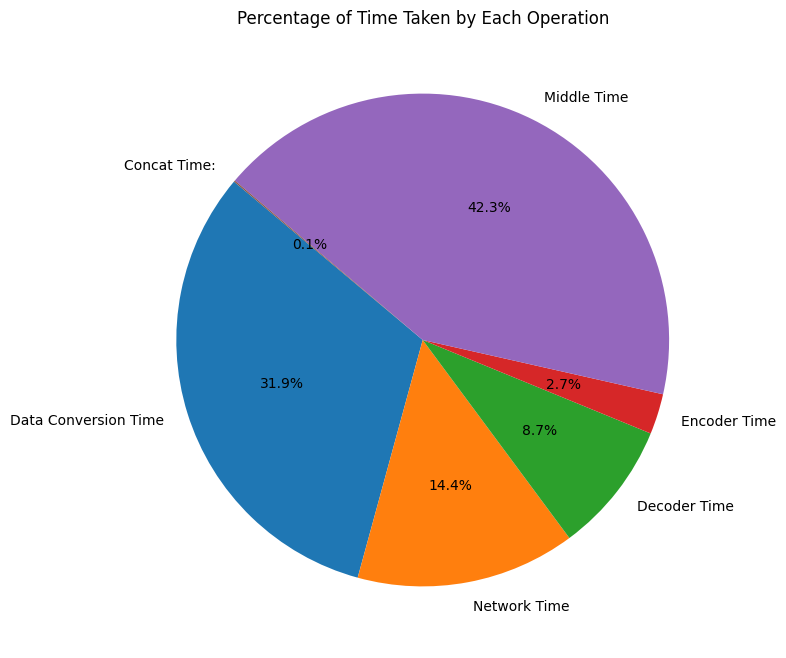

Average Times:
Data Conversion Time: 0.0253
Network Time: 0.0114
Decoder Time: 0.0069
Encoder Time: 0.0021
Middle Time: 0.0336
Concat Time:: 0.0001


In [82]:
# Calculate the average time across all steps and experiments
avg_total_conversion_time = np.mean(conversion_time)
avg_network_time = np.mean(network_time)
avg_dec_time = np.mean(dec_time)
avg_enc_time = np.mean(enc_time)
avg_middle_time = np.mean(middle_time)
avg_concat_time = np.mean(concat_time)
# Aggregate the average times
average_times = {
    "Data Conversion Time": avg_total_conversion_time,
    "Network Time": avg_network_time,
    "Decoder Time": avg_dec_time,
    "Encoder Time": avg_enc_time,
    "Middle Time": avg_middle_time,
    "Concat Time:": avg_concat_time
}

# --- Visualization ---

# Create a pie chart
labels = average_times.keys()
sizes = average_times.values()

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Percentage of Time Taken by Each Operation")
plt.show()

# Print the average times for reference
print("Average Times:")
for label, time in average_times.items():
    print(f"{label}: {time:.4f}")

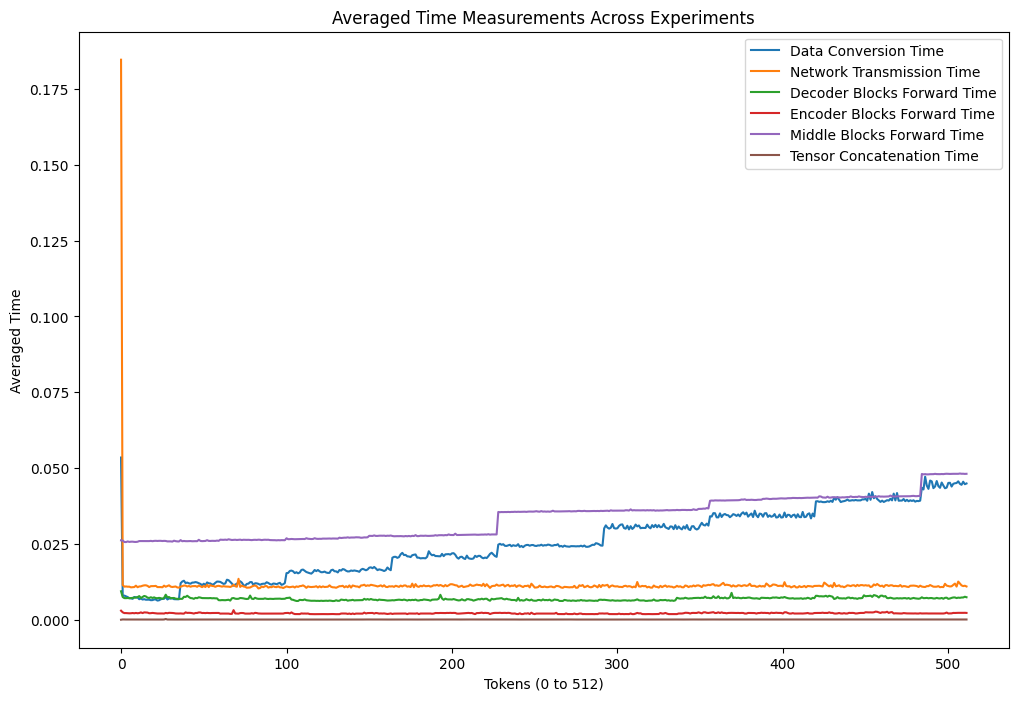

First 10 steps of averaged results:
Data Conversion Time: [0.053482611974080406, 0.007936795552571615, 0.00795125961303711, 0.00771339734395345, 0.0074681440989176435, 0.007114728291829427, 0.007062991460164388, 0.006891091664632161, 0.007492860158284505, 0.007395029067993164]
Network Request Time: [0.18467132250467935, 0.01142724355061849, 0.010895808537801107, 0.010972261428833008, 0.01089008649190267, 0.010900735855102539, 0.010679324467976889, 0.010726213455200195, 0.010778506596883139, 0.011228243509928385]
Decoder Time: [0.009378910064697266, 0.007486422856648763, 0.007128794987996419, 0.007114807764689128, 0.007164557774861653, 0.007096290588378906, 0.007129192352294922, 0.0072031815846761065, 0.00729521115620931, 0.00728456179300944]
Encoder Time: [0.002977132797241211, 0.002441883087158203, 0.0021883646647135415, 0.002194086710611979, 0.002158085505167643, 0.002115170160929362, 0.0021359920501708984, 0.0022117296854654946, 0.0021289984385172525, 0.002236048380533854]
Middle Ti

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual lists)
# conversion_time_1 = [...]  # Replace with actual data
# conversion_time_2 = [...]  # Replace with actual data
# network_time = [...]       # Replace with actual data
# dec_time = [...]           # Replace with actual data
# enc_time = [...]           # Replace with actual data

# Define the number of steps per experiment
steps_per_experiment = 512
num_experiments = 3

# Function to calculate the averaged time for each step across experiments
def average_across_experiments(data):
    return [
        np.mean([data[steps_per_experiment * j + i] for j in range(num_experiments)])
        for i in range(steps_per_experiment)
    ]

# Sum conversion_time_1 and conversion_time_2
# total_conversion_time = [c1 + c2 for c1, c2 in zip(conversion_time_1, conversion_time_2)]

# Apply the function to the summed conversion time and other lists
avg_total_conversion_time = average_across_experiments(conversion_time)
avg_middle_time = average_across_experiments(middle_time)
avg_network_time = average_across_experiments(network_time)
avg_dec_time = average_across_experiments(dec_time)
avg_enc_time = average_across_experiments(enc_time)
avg_concat_time = average_across_experiments(concat_time)

# --- Visualization ---

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(avg_total_conversion_time, label="Data Conversion Time")
plt.plot(avg_network_time, label="Network Transmission Time")
plt.plot(avg_dec_time, label="Decoder Blocks Forward Time")
plt.plot(avg_enc_time, label="Encoder Blocks Forward Time")
plt.plot(avg_middle_time, label="Middle Blocks Forward Time")
plt.plot(avg_concat_time, label="Tensor Concatenation Time")
plt.title("Averaged Time Measurements Across Experiments")
plt.xlabel("Tokens (0 to 512)")
plt.ylabel("Averaged Time")
plt.legend()
plt.show()

# Print the first few averaged values for verification
print("First 10 steps of averaged results:")
print("Data Conversion Time:", avg_total_conversion_time[:10])
print("Network Request Time:", avg_network_time[:10])
print("Decoder Time:", avg_dec_time[:10])
print("Encoder Time:", avg_enc_time[:10])
print("Middle Time:", avg_middle_time[:10])
print("Concat Time:", avg_concat_time[:10])


In [13]:
#### CPU

In [18]:
import time

class XCodeEncDecModel(PreTrainedModel):
    config_class = XCodeEncDecConfig

    def __init__(self, config: XCodeEncDecConfig):
        super().__init__(config)
        self.enc_time = []
        self.conversion_time = []
        self.network_time = []
        self.dec_time = []
        self.middle_time = []
        self.concat_time = []
        self.last_middle = None
        self.conversion_time_1 = []
        self.conversion_time_2 = []
        self.cloud_conversion_time_1 = []
        self.cloud_conversion_time_2 = []
        

        # Set up Encoder
        enc_config = AutoConfig.from_pretrained(config.enc_dec_origin_model)
        self.enc = AutoModel.from_config(enc_config)
        self.enc.layers = self.enc.layers[: config.enc_num_layers]
        self.enc.norm = nn.Identity()

        # Set up Decoder
        dec_config = AutoConfig.from_pretrained(config.enc_dec_origin_model)
        self.dec = AutoModelForCausalLM.from_config(
            dec_config
        )
        self.dec.model.layers = self.dec.model.layers[- config.dec_num_layers :]
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Union[Cache, List[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = False,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        cache_position: Optional[torch.LongTensor] = None,
    ) -> Union[Tuple, CausalLMOutputWithPast]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict


        enc_start = time.time()
        enc_output = self.enc(
            input_ids=input_ids,
            attention_mask=attention_mask,
            use_cache=False,
        )
        enc_end = time.time()
        self.enc_time.append(enc_end - enc_start)


        conversion_time_start_1 = time.time()
        if self.last_middle is None:
            input_embeds_list = enc_output.last_hidden_state.detach().cpu().to(torch.float16).numpy().tolist()
        else: 
            input_embeds_list = enc_output.last_hidden_state[:,-1:,:].detach().cpu().to(torch.float16).numpy().tolist()
        # attention_mask_list = attention_mask.detach().cpu().numpy().tolist() if attention_mask is not None else None
        conversion_time_end_1 = time.time()
        conversion_time = conversion_time_end_1 - conversion_time_start_1
        self.conversion_time_1.append(conversion_time)
        
        network_time_start = time.time()
        import requests
        network_time = None
        conversion_time_2 = None

        
        # print(enc_output.last_hidden_state.shape)
        # Prepare request payload
        payload = {
            "inputs_embeds": input_embeds_list,
        }
        cloud_concat = 0
        # Make request to the middle model API
        try:
            response = requests.post("http://localhost:9000/predict", json=payload)
            response.raise_for_status()  # Raise an exception for bad status codes
            network_time_end = time.time()
            
            conversion_time_start_2 = time.time()
            # Convert the response back to tensor
            response_json = response.json()
            middle_output_list = response_json["last_hidden_state"]
            conversion_time_cloud_1 = response_json["conversion_time_1"]
            conversion_time_cloud_2 = response_json["conversion_time_2"]
            middle_time = response_json["middle_time"]
            cloud_concat = response_json["concat_time"]
            middle_hidden_state = torch.tensor(middle_output_list, device=self.dec.device, dtype=torch.float16)
            
            # Create a BaseModelOutputWithPast-like object
            class MiddleOutput:
                def __init__(self, last_hidden_state):
                    self.last_hidden_state = last_hidden_state
            
            network_middle_output = MiddleOutput(last_hidden_state=middle_hidden_state)
            conversion_time_end_2 = time.time()
            conversion_time = conversion_time + (conversion_time_end_2 - conversion_time_start_2) + conversion_time_cloud_1 + conversion_time_cloud_2
            
            self.conversion_time_2.append((conversion_time_end_2 - conversion_time_start_2))
            self.cloud_conversion_time_1.append(conversion_time_cloud_1)
            self.cloud_conversion_time_2.append(conversion_time_cloud_2)
        except requests.exceptions.RequestException as e:
            network_time_end = time.time()
            raise RuntimeError(f"Failed to get middle model output: {str(e)}")
            
        network_time = network_time_end - network_time_start - conversion_time_cloud_1 - conversion_time_cloud_2 - middle_time - cloud_concat
        
        
        self.network_time.append(network_time)
        self.middle_time.append(middle_time)
        
        concat_time_start = time.time()
        if self.last_middle is None:
            middle_output = network_middle_output.last_hidden_state.to(self.dec.device)
            
        else: 
            middle_output = torch.concat((self.last_middle, network_middle_output.last_hidden_state), dim=1)
        concat_time_end = time.time()
        self.last_middle = middle_output
        self.concat_time.append(concat_time_end - concat_time_start + cloud_concat)
        # print(middle_output.shape)
        dec_start = time.time()
        dec_output = self.dec(
            inputs_embeds=middle_output,
            attention_mask=attention_mask,
            use_cache=False,
            labels=labels,
        )
        dec_end = time.time()
        self.dec_time.append(dec_end - dec_start)
        self.conversion_time.append(conversion_time)
        return dec_output
    def prepare_inputs_for_generation(
        self, input_ids, past_key_values=None, attention_mask=None, inputs_embeds=None, **kwargs
    ):
        return self.dec.prepare_inputs_for_generation(input_ids, past_key_values, attention_mask, inputs_embeds, **kwargs)

class XCodeModelForCausalLM(XCodeEncDecModel, GenerationMixin):
    def save_pretrained(
        self,
        save_directory: Union[str, os.PathLike],
        is_main_process: bool = True,
        save_function: Callable = torch.save,
        push_to_hub: bool = False,
        max_shard_size: Union[int, str] = "5GB",
        safe_serialization: bool = False,
        variant: Optional[str] = None,
        token: Optional[Union[str, bool]] = None,
        save_peft_format: bool = True,
        **kwargs,
    ):
        state_dict = {k: v for k, v in self.state_dict().items()}
    
        # Remove state_dict from kwargs if it's present
        kwargs.pop('state_dict', None)
        
        # Call the parent class's save_pretrained method with the filtered state_dict
        super().save_pretrained(
            save_directory,
            state_dict=state_dict,
            is_main_process=is_main_process,
            save_function=save_function,
            push_to_hub=push_to_hub,
            max_shard_size=max_shard_size,
            safe_serialization=False,
            #safe_serialization=safe_serialization,
            variant=variant,
            token=token,
            save_peft_format=save_peft_format,
            **kwargs,
        )

In [ ]:
# SLOW WULVER!!!!
AutoConfig.register("xcodeencdec", XCodeEncDecConfig)
AutoModel.register(XCodeEncDecConfig, XCodeEncDecModel)
AutoModelForCausalLM.register(XCodeEncDecConfig, XCodeModelForCausalLM)
model = AutoModelForCausalLM.from_pretrained("enc_dec", device_map="cpu", torch_dtype=torch.float16)
from tqdm import tqdm
device = "cpu"
prompt = "Write a quicksort algorithm in python."
ITER_NUM = 3
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
model = model.cpu()
model.enc = model.enc.cpu().to(torch.float16)
model.dec = model.dec.cpu().to(torch.float16)
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)
responses = []
for i in tqdm(range(ITER_NUM)):
    import requests
    requests.post("http://localhost:9000/clear")
    model.last_middle = None
    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=512
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    
    responses.append(tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|                                                                                                                                                                                      | 0/3 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


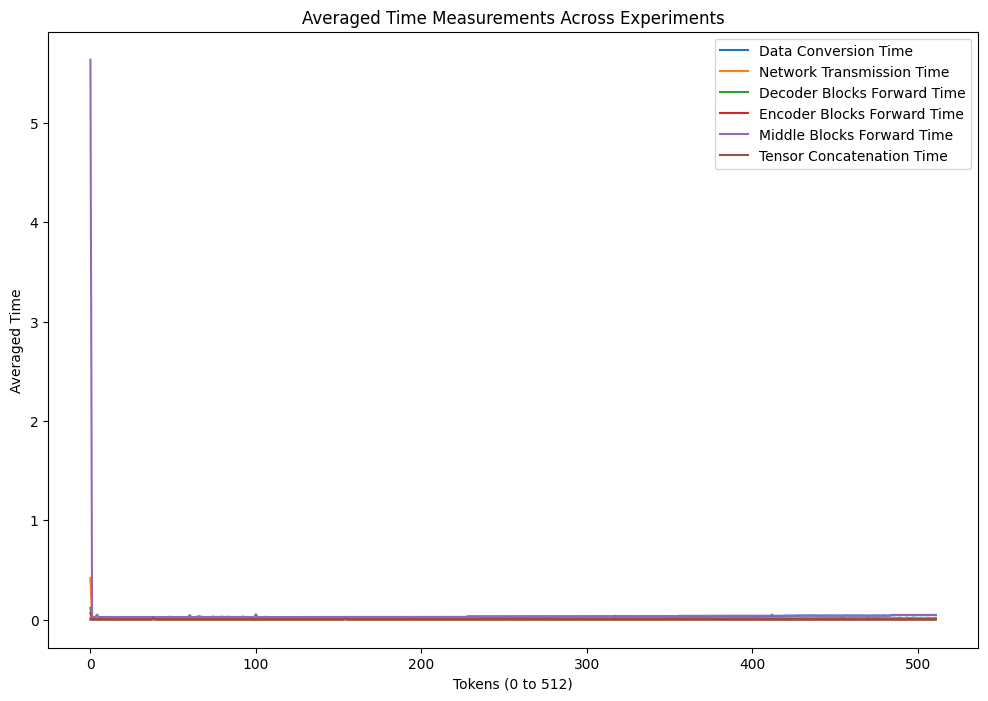

First 10 steps of averaged results:
Data Conversion Time: [0.11958352724711101, 0.008287986119588217, 0.007946252822875977, 0.007941007614135742, 0.007688363393147786, 0.00772555669148763, 0.008861859639485678, 0.007862011591593424, 0.007866859436035156, 0.008006413777669271]
Network Request Time: [0.42120544115702313, 0.015905062357584637, 0.01398142178853353, 0.014419794082641602, 0.014077345530192057, 0.014334996541341146, 0.014001925786336264, 0.013984998067220053, 0.013906240463256836, 0.013951619466145834]
Decoder Time: [0.012827873229980469, 0.012505928675333658, 0.012679974238077799, 0.012679974238077799, 0.012221813201904297, 0.0136567751566569, 0.013238668441772461, 0.012385686238606771, 0.012759526570638021, 0.010928948720296225]
Encoder Time: [0.0661333401997884, 0.003988742828369141, 0.003938754399617513, 0.003962039947509766, 0.0040436585744222, 0.003969033559163411, 0.00435026486714681, 0.0040587584177653, 0.0040407975514729815, 0.0036963621775309243]
Middle Time: [5.635

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual lists)
# conversion_time_1 = [...]  # Replace with actual data
# conversion_time_2 = [...]  # Replace with actual data
# network_time = [...]       # Replace with actual data
# dec_time = [...]           # Replace with actual data
# enc_time = [...]           # Replace with actual data

# Define the number of steps per experiment
steps_per_experiment = 512
num_experiments = 3

# Function to calculate the averaged time for each step across experiments
def average_across_experiments(data):
    return [
        np.mean([data[steps_per_experiment * j + i] for j in range(num_experiments)])
        for i in range(steps_per_experiment)
    ]

# Sum conversion_time_1 and conversion_time_2
# total_conversion_time = [c1 + c2 for c1, c2 in zip(conversion_time_1, conversion_time_2)]

# Apply the function to the summed conversion time and other lists
avg_total_conversion_time = average_across_experiments(conversion_time)
avg_middle_time = average_across_experiments(middle_time)
avg_network_time = average_across_experiments(network_time)
avg_dec_time = average_across_experiments(dec_time)
avg_enc_time = average_across_experiments(enc_time)
avg_concat_time = average_across_experiments(concat_time)

# --- Visualization ---

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(avg_total_conversion_time, label="Data Conversion Time")
plt.plot(avg_network_time, label="Network Transmission Time")
plt.plot(avg_dec_time, label="Decoder Blocks Forward Time")
plt.plot(avg_enc_time, label="Encoder Blocks Forward Time")
plt.plot(avg_middle_time, label="Middle Blocks Forward Time")
plt.plot(avg_concat_time, label="Tensor Concatenation Time")
plt.title("Averaged Time Measurements Across Experiments")
plt.xlabel("Tokens (0 to 512)")
plt.ylabel("Averaged Time")
plt.legend()
plt.show()

# Print the first few averaged values for verification
print("First 10 steps of averaged results:")
print("Data Conversion Time:", avg_total_conversion_time[:10])
print("Network Request Time:", avg_network_time[:10])
print("Decoder Time:", avg_dec_time[:10])
print("Encoder Time:", avg_enc_time[:10])
print("Middle Time:", avg_middle_time[:10])
print("Concat Time:", avg_concat_time[:10])


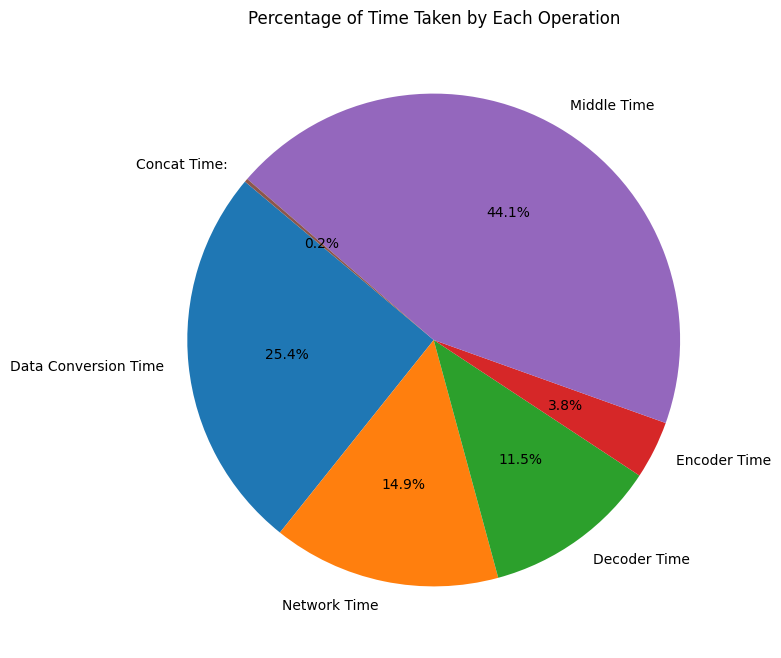

Average Times:
Data Conversion Time: 0.0261
Network Time: 0.0154
Decoder Time: 0.0118
Encoder Time: 0.0039
Middle Time: 0.0453
Concat Time:: 0.0002


In [17]:
# Calculate the average time across all steps and experiments
avg_total_conversion_time = np.mean(conversion_time)
avg_network_time = np.mean(network_time)
avg_dec_time = np.mean(dec_time)
avg_enc_time = np.mean(enc_time)
avg_middle_time = np.mean(middle_time)
avg_concat_time = np.mean(concat_time)
# Aggregate the average times
average_times = {
    "Data Conversion Time": avg_total_conversion_time,
    "Network Time": avg_network_time,
    "Decoder Time": avg_dec_time,
    "Encoder Time": avg_enc_time,
    "Middle Time": avg_middle_time,
    "Concat Time:": avg_concat_time
}

# --- Visualization ---

# Create a pie chart
labels = average_times.keys()
sizes = average_times.values()

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Percentage of Time Taken by Each Operation")
plt.show()

# Print the average times for reference
print("Average Times:")
for label, time in average_times.items():
    print(f"{label}: {time:.4f}")

# ORJSON experiment

In [31]:
import time
import orjson
class XCodeEncDecModel(PreTrainedModel):
    config_class = XCodeEncDecConfig

    def __init__(self, config: XCodeEncDecConfig):
        super().__init__(config)
        self.enc_time = []
        self.conversion_time = []
        self.network_time = []
        self.dec_time = []
        self.middle_time = []
        self.concat_time = []
        self.last_middle = None
        self.conversion_time_1 = []
        self.conversion_time_2 = []
        self.cloud_conversion_time_1 = []
        self.cloud_conversion_time_2 = []
        

        # Set up Encoder
        enc_config = AutoConfig.from_pretrained(config.enc_dec_origin_model)
        self.enc = AutoModel.from_config(enc_config, torch_dtype=torch.bfloat16)
        self.enc.layers = self.enc.layers[: config.enc_num_layers]
        self.enc.norm = nn.Identity()

        # Set up Decoder
        dec_config = AutoConfig.from_pretrained(config.enc_dec_origin_model)
        self.dec = AutoModelForCausalLM.from_config(
            dec_config, torch_dtype=torch.bfloat16
        )
        self.dec.model.layers = self.dec.model.layers[- config.dec_num_layers :]
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Union[Cache, List[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = False,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        cache_position: Optional[torch.LongTensor] = None,
    ) -> Union[Tuple, CausalLMOutputWithPast]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict


        enc_start = time.time()
        enc_output = self.enc(
            input_ids=input_ids,
            attention_mask=attention_mask,
            use_cache=False,
        )
        enc_end = time.time()
        self.enc_time.append(enc_end - enc_start)


        conversion_time_start_1 = time.time()
        if self.last_middle is None:
            input_embeds_list = enc_output.last_hidden_state.detach().to(torch.float16).cpu().numpy()
        else: 
            input_embeds_list = enc_output.last_hidden_state[:,-1:,:].detach().to(torch.float16).cpu().numpy()
        # attention_mask_list = attention_mask.detach().cpu().numpy().tolist() if attention_mask is not None else None
        conversion_time_end_1 = time.time()
        conversion_time = conversion_time_end_1 - conversion_time_start_1
        self.conversion_time_1.append(conversion_time)
        
        network_time_start = time.time()
        import requests
        network_time = None
        conversion_time_2 = None

        
        # print(enc_output.last_hidden_state.shape)
        # Prepare request payload
        # payload = {
        #     "inputs_embeds": input_embeds_list,
        # }
        json_string = orjson.dumps({"inputs_embeds": input_embeds_list},option=orjson.OPT_SERIALIZE_NUMPY)
        cloud_concat = 0
        # Make request to the middle model API
        try:
            response = requests.post("http://localhost:9000/predict", data=json_string, headers={'Content-type': 'application/json'})
            response.raise_for_status()  # Raise an exception for bad status codes
            network_time_end = time.time()
            
            conversion_time_start_2 = time.time()
            # Convert the response back to tensor
            response_json = response.json()
            middle_output_list = response_json["last_hidden_state"]
            conversion_time_cloud_1 = response_json["conversion_time_1"]
            conversion_time_cloud_2 = response_json["conversion_time_2"]
            middle_time = response_json["middle_time"]
            cloud_concat = response_json["concat_time"]
            middle_hidden_state = torch.tensor(middle_output_list, dtype=torch.float16, pin_memory=True).to(device=self.dec.device, dtype=torch.bfloat16, non_blocking=True)
            
            # Create a BaseModelOutputWithPast-like object
            class MiddleOutput:
                def __init__(self, last_hidden_state):
                    self.last_hidden_state = last_hidden_state
            
            # network_middle_output = MiddleOutput(last_hidden_state=middle_hidden_state)
            conversion_time_end_2 = time.time()
            conversion_time = conversion_time + (conversion_time_end_2 - conversion_time_start_2) + conversion_time_cloud_1 + conversion_time_cloud_2
            
            self.conversion_time_2.append((conversion_time_end_2 - conversion_time_start_2))
            self.cloud_conversion_time_1.append(conversion_time_cloud_1)
            self.cloud_conversion_time_2.append(conversion_time_cloud_2)
        except requests.exceptions.RequestException as e:
            network_time_end = time.time()
            raise RuntimeError(f"Failed to get middle model output: {str(e)}")
            
        network_time = network_time_end - network_time_start - conversion_time_cloud_1 - conversion_time_cloud_2 - middle_time - cloud_concat
        
        
        self.network_time.append(network_time)
        self.middle_time.append(middle_time)
        
        concat_time_start = time.time()
        if self.last_middle is None:
            middle_output = middle_hidden_state
            
        else: 
            middle_output = torch.concat((self.last_middle, middle_hidden_state), dim=1)
        concat_time_end = time.time()
        self.last_middle = middle_output
        self.concat_time.append(concat_time_end - concat_time_start + cloud_concat)
        # print(middle_output.shape)
        dec_start = time.time()
        dec_output = self.dec(
            inputs_embeds=middle_output,
            attention_mask=attention_mask,
            use_cache=False,
            labels=labels,
        )
        dec_end = time.time()
        self.dec_time.append(dec_end - dec_start)
        self.conversion_time.append(conversion_time)
        return dec_output
    def prepare_inputs_for_generation(
        self, input_ids, past_key_values=None, attention_mask=None, inputs_embeds=None, **kwargs
    ):
        return self.dec.prepare_inputs_for_generation(input_ids, past_key_values, attention_mask, inputs_embeds, **kwargs)

class XCodeModelForCausalLM(XCodeEncDecModel, GenerationMixin):
    def save_pretrained(
        self,
        save_directory: Union[str, os.PathLike],
        is_main_process: bool = True,
        save_function: Callable = torch.save,
        push_to_hub: bool = False,
        max_shard_size: Union[int, str] = "5GB",
        safe_serialization: bool = False,
        variant: Optional[str] = None,
        token: Optional[Union[str, bool]] = None,
        save_peft_format: bool = True,
        **kwargs,
    ):
        state_dict = {k: v for k, v in self.state_dict().items()}
    
        # Remove state_dict from kwargs if it's present
        kwargs.pop('state_dict', None)
        
        # Call the parent class's save_pretrained method with the filtered state_dict
        super().save_pretrained(
            save_directory,
            state_dict=state_dict,
            is_main_process=is_main_process,
            save_function=save_function,
            push_to_hub=push_to_hub,
            max_shard_size=max_shard_size,
            safe_serialization=False,
            #safe_serialization=safe_serialization,
            variant=variant,
            token=token,
            save_peft_format=save_peft_format,
            **kwargs,
        )

In [32]:
AutoConfig.register("xcodeencdec", XCodeEncDecConfig)
AutoModel.register(XCodeEncDecConfig, XCodeEncDecModel)
AutoModelForCausalLM.register(XCodeEncDecConfig, XCodeModelForCausalLM)

In [33]:
model = AutoModelForCausalLM.from_pretrained("enc_dec", device_map="cuda:3", torch_dtype=torch.bfloat16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [34]:
from tqdm import tqdm
device = "cuda:3"
prompt = "Write a quicksort algorithm in python."
ITER_NUM = 3
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
# model = model.cuda()
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)
responses = []
for i in tqdm(range(ITER_NUM)):
    import requests
    requests.post("http://localhost:9000/clear")
    model.last_middle = None
    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=512
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    
    responses.append(tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0])

  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 33%|████████████████████████████████████████████████                                                                                                | 1/3 [01:46<03:33, 106.67s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                             

In [35]:
conversion_time = model.conversion_time
middle_time = model.middle_time
network_time = model.network_time
dec_time = model.dec_time
enc_time = model.enc_time
concat_time = model.concat_time
conversion_time_1 = model.conversion_time_1
conversion_time_2 = model.conversion_time_2
conversion_time_cloud_1= model.cloud_conversion_time_1
conversion_time_cloud_2= model.cloud_conversion_time_2

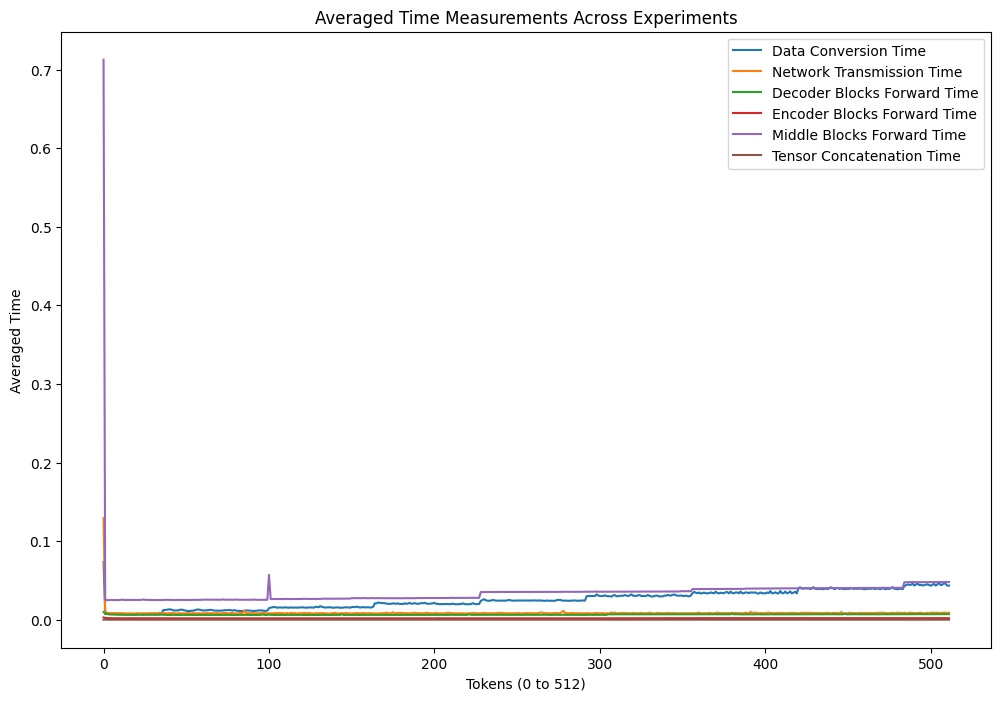

First 10 steps of averaged results:
Data Conversion Time: [0.07348267237345378, 0.007226705551147461, 0.007448116938273112, 0.00741116205851237, 0.007301648457845052, 0.007409254709879558, 0.00743563969930013, 0.0075444380442301435, 0.007260878880818685, 0.0069361527760823565]
Network Request Time: [0.12923296292622885, 0.009702205657958984, 0.008903264999389648, 0.008482138315836588, 0.008341312408447266, 0.0082856814066569, 0.008517821629842123, 0.008406400680541992, 0.00830698013305664, 0.00840155283610026]
Decoder Time: [0.009762207667032877, 0.007783651351928711, 0.007608493169148763, 0.006797949473063151, 0.006650447845458984, 0.006557464599609375, 0.006618022918701172, 0.0064271291097005205, 0.006389458974202474, 0.006318569183349609]
Encoder Time: [0.0028949578603108725, 0.0022842089335123696, 0.0020923614501953125, 0.001965045928955078, 0.0020029544830322266, 0.001878817876180013, 0.0019069512685139973, 0.0018881162007649739, 0.0018660227457682292, 0.0018419424692789714]
Middl

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual lists)
# conversion_time_1 = [...]  # Replace with actual data
# conversion_time_2 = [...]  # Replace with actual data
# network_time = [...]       # Replace with actual data
# dec_time = [...]           # Replace with actual data
# enc_time = [...]           # Replace with actual data

# Define the number of steps per experiment
steps_per_experiment = 512
num_experiments = 3

# Function to calculate the averaged time for each step across experiments
def average_across_experiments(data):
    return [
        np.mean([data[steps_per_experiment * j + i] for j in range(num_experiments)])
        for i in range(steps_per_experiment)
    ]

# Sum conversion_time_1 and conversion_time_2
# total_conversion_time = [c1 + c2 for c1, c2 in zip(conversion_time_1, conversion_time_2)]

# Apply the function to the summed conversion time and other lists
avg_total_conversion_time = average_across_experiments(conversion_time)
avg_middle_time = average_across_experiments(middle_time)
avg_network_time = average_across_experiments(network_time)
avg_dec_time = average_across_experiments(dec_time)
avg_enc_time = average_across_experiments(enc_time)
avg_concat_time = average_across_experiments(concat_time)

# --- Visualization ---

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(avg_total_conversion_time, label="Data Conversion Time")
plt.plot(avg_network_time, label="Network Transmission Time")
plt.plot(avg_dec_time, label="Decoder Blocks Forward Time")
plt.plot(avg_enc_time, label="Encoder Blocks Forward Time")
plt.plot(avg_middle_time, label="Middle Blocks Forward Time")
plt.plot(avg_concat_time, label="Tensor Concatenation Time")
plt.title("Averaged Time Measurements Across Experiments")
plt.xlabel("Tokens (0 to 512)")
plt.ylabel("Averaged Time")
plt.legend()
plt.show()

# Print the first few averaged values for verification
print("First 10 steps of averaged results:")
print("Data Conversion Time:", avg_total_conversion_time[:10])
print("Network Request Time:", avg_network_time[:10])
print("Decoder Time:", avg_dec_time[:10])
print("Encoder Time:", avg_enc_time[:10])
print("Middle Time:", avg_middle_time[:10])
print("Concat Time:", avg_concat_time[:10])


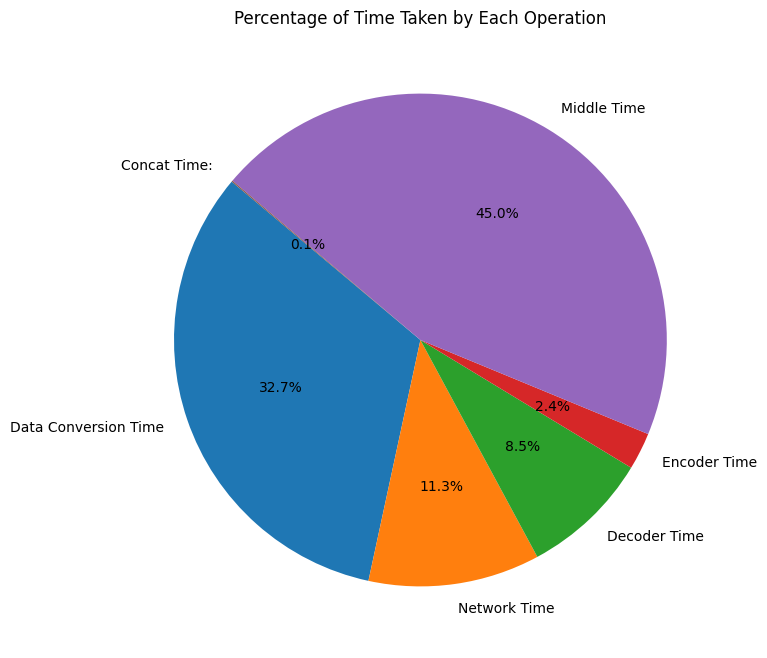

Average Times:
Data Conversion Time: 0.0252
Network Time: 0.0087
Decoder Time: 0.0065
Encoder Time: 0.0019
Middle Time: 0.0346
Concat Time:: 0.0001


In [37]:
# Calculate the average time across all steps and experiments
avg_total_conversion_time = np.mean(conversion_time)
avg_network_time = np.mean(network_time)
avg_dec_time = np.mean(dec_time)
avg_enc_time = np.mean(enc_time)
avg_middle_time = np.mean(middle_time)
avg_concat_time = np.mean(concat_time)
# Aggregate the average times
average_times = {
    "Data Conversion Time": avg_total_conversion_time,
    "Network Time": avg_network_time,
    "Decoder Time": avg_dec_time,
    "Encoder Time": avg_enc_time,
    "Middle Time": avg_middle_time,
    "Concat Time:": avg_concat_time
}

# --- Visualization ---

# Create a pie chart
labels = average_times.keys()
sizes = average_times.values()

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Percentage of Time Taken by Each Operation")
plt.show()

# Print the average times for reference
print("Average Times:")
for label, time in average_times.items():
    print(f"{label}: {time:.4f}")